In [1]:
import re
import warnings
import json

import kinotochka_helpers as kh
from inference_helpers import AddOne, StringToList

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, Lambda, Dot, BatchNormalization, LeakyReLU, Dense
from tensorflow.keras.models import Model


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import random as tf_random

from sklearn.metrics import r2_score, mean_absolute_error


import plotly.graph_objects as go
from plotly.subplots import make_subplots

import joblib
from keras import backend as K
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
%config Completer.use_jedi = False

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

RANDOM = 202309

In [2]:
temporary_data = [
    'User-2023-10-07.csv',
    'Movie-2023-10-08.csv',
    'RatingMovie-2023-10-07.csv'
]

df_users = pd.read_csv(f'.\\cached_data\\{temporary_data[0]}').rename(columns={'id': 'user', 'fav_genres.1': 'favorited_genres'})
df_movies = pd.read_csv(f'.\\cached_data\\{temporary_data[1]}').rename(columns={'id': 'movie_id'})
df_ratings = pd.read_csv(f'.\\cached_data\\{temporary_data[2]}').rename(columns={'id': 'rate_id', 'movie': 'movie_id'})

In [3]:
for i in [df_users, df_movies, df_ratings]:
    display(i.head(3))
    print(i.shape)

,user,sex,date_of_birth,fav_genres,favorited_genres
0,fb71a023-2fd4-4503-9343-2517a85583c4,NaN,0,NaN,NaN
1,f82405e8-bb0d-49c2-8a8f-b0e59e0ce3c9,NaN,0,NaN,NaN
2,f740d32e-cf84-4114-a283-d066f94fe450,NaN,0,Фэнтези Мультфильм Мелодрама Комедия,5 3 2 1


(67, 5)


,movie_id,title,original_title,description,v_picture,h_picture,premiere_date,rating_avg,rate_imdb,rate_kinopoisk,duration_minutes,age_limit,view_count,genres,actors,directors,countries,categories,favorite_for,need_to_see,trailer_link
0,125,Тибра,NaN,"Девочка-изгой уверяет всех, что маленькую Катю...",images/movies/тибра_вертикаль.webp,images/movies/тибра_горизонталь.webp,2022-01-01,0.0,0.0,6.1,84,18,33,11,"795,791,793,794,792,796,798,799,797",121,2,1,"d4c72276-946f-4776-91f3-afed5d53df48,58ed4fc8-...","de14e808-7cfd-4b90-82f6-624664ed2e4b,d4c72276-...",https://youtube.com/embed/7ES3eT3sIWg
1,70,Боудика — королева воинов,Boudica: Rise of the Warrior Queen,Вождь кельтского клана хочет отдать свою шестн...,images/movies/Боудика_королева_воинов_вертикал...,images/movies/Боудика_королева_воинов_горизонт...,2019-01-01,0.0,3.1,4.9,82,18,55,16,"446,448,447,445,444",74,6,1,"d4c72276-946f-4776-91f3-afed5d53df48,5018f760-...","de14e808-7cfd-4b90-82f6-624664ed2e4b,d4c72276-...",www.youtube.com/embed/4QsUtK-d29I
2,115,Почти как люди,Humains,Французский профессор-антрополог находит инфор...,images/movies/почти_как_люди_вертикаль.webp,images/movies/почти_как_люди_горизонталь.webp,2009-01-01,0.0,3.5,4.3,90,16,44,"11,10,7,6","704,711,708,703,710,709,705,702,707,706","112,113","20,5,19",1,d4c72276-946f-4776-91f3-afed5d53df48,"de14e808-7cfd-4b90-82f6-624664ed2e4b,d4c72276-...",https://youtube.com/embed/cbHvF-DI0qg


(150, 21)


,rate_id,user,rate,movie_id
0,624,b4d01943-e7b5-4a59-973d-97a087ab95ec,8,2
1,623,d4c72276-946f-4776-91f3-afed5d53df48,4,40
2,622,d4c72276-946f-4776-91f3-afed5d53df48,5,114


(549, 4)


In [4]:
initial_columns_order = [
            'user',
            'sex',
            'date_of_birth',
            'favorited_genres',
            'movie_id',
            'rate_imdb',
            'rate_kinopoisk',
            'duration_minutes',
            'premiere_date',
            'age_limit',
            'genres',
            'actors',
            'directors',
            'countries',
            'rate'
        ]

In [5]:
# merge tables
data = (
    df_ratings
    .merge(
        df_movies, how='left', on='movie_id'
    )
    .merge(
        df_users, how='left', on='user'
    )
    [initial_columns_order]
)

In [6]:
data['premiere_date'] = pd.to_datetime(data['premiere_date']).dt.year
data['favorited_genres'] = data['favorited_genres'].fillna('0')

In [7]:
display(data.head(3))
print(data.shape)

,user,sex,date_of_birth,favorited_genres,movie_id,rate_imdb,rate_kinopoisk,duration_minutes,premiere_date,age_limit,genres,actors,directors,countries,rate
0,b4d01943-e7b5-4a59-973d-97a087ab95ec,NaN,0,15 5 3,2,8.9,8.7,140,2023,0,"3,4,5,6,7,8","4,6,8,10,9,11,5,7,3,2","4,2,3",1,8
1,d4c72276-946f-4776-91f3-afed5d53df48,Female,24,2 1,40,5.2,6.2,87,2007,6,"8,1","294,293,290,296,291,299,292,295,298,297",44,1,4
2,d4c72276-946f-4776-91f3-afed5d53df48,Female,24,2 1,114,5.1,4.8,102,2008,16,"11,10,9","700,697,696,693,701,695,692,694,698,699",111,2,5


(549, 15)


---

In [8]:
list_transform_columns = ['genres', 'actors', 'favorited_genres', 'directors', 'countries']
ohe_encoding_columns = ['sex']
id_columns = ['user', 'movie_id']
numerical_encoding_columns = ['date_of_birth', 'rate_imdb', 'rate_kinopoisk', 'duration_minutes', 'age_limit', 'premiere_date']


user_id_transform_pipe = Pipeline([
    ('encode', OrdinalEncoder(unknown_value=-1, handle_unknown='use_encoded_value')),
    ('add_one', AddOne())
])

preprocessor_st1 = ColumnTransformer(
    transformers=[
        ('id_columns', user_id_transform_pipe, id_columns),
        ('list_features', StringToList(), list_transform_columns),
    ],
    remainder='passthrough'
)

new_columns_order_st1 = [
    'user', 'movie_id', 'genres', 'actors', 'favorited_genres',
    'directors', 'countries', 'sex', 'date_of_birth', 'rate_imdb',
    'rate_kinopoisk', 'duration_minutes', 'premiere_date', 'age_limit', 'rate'
]

In [9]:
preprocessor_st1.fit(data)
fixed_data = pd.DataFrame(preprocessor_st1.transform(data), columns=new_columns_order_st1)

In [10]:
# joblib.dump(preprocessor_st1, 'stage1preprocessor')

In [11]:
# kh.data_metrics(
#     mode='dump',
#     data = fixed_data[
#         ['user','movie_id', 'genres', 'actors',
#          'favorited_genres', 'directors', 'countries']
#     ]
# )

# kh.data_metrics(
#     data=df_movies,
#     mode='count',
#     columns=['movie_id', 'genres',
#              'actors', 'directors',
#              'countries']
# )

In [12]:
data_metrics_json = kh.data_metrics(mode='load')

In [13]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    fixed_data.drop('rate', axis=1),
    fixed_data['rate'],
    shuffle=True,
    random_state=RANDOM,
    test_size=.2
)

In [15]:
preprocessor_st2 = ColumnTransformer(
        transformers=[
            ('ohe_features', OneHotEncoder(sparse=False, drop='first'), ohe_encoding_columns),
            ('numerical_features', MinMaxScaler(), numerical_encoding_columns),
        ],
        remainder='passthrough'
    )

In [18]:
preprocessor_st2.fit(fixed_data.drop('rate', axis=1))

X_train = pd.DataFrame(preprocessor_st2.transform(X_train_raw))
X_test = pd.DataFrame(preprocessor_st2.transform(X_test_raw))

In [ ]:
# joblib.dump(preprocessor_st2, 'stage2preprocessor')

In [19]:
def prepare_data(data):
    
    data_metrics_json = kh.data_metrics(mode='load')

    input_user = np.array(data[8].astype(int))
    input_movie = np.array(data[9].astype(int))
    input_gender_0 = np.array(data[0].astype(int))
    input_gender_1 = np.array(data[1].astype(int))
    input_age = np.array(data[2])
    input_imdb = np.array(data[3])
    input_kinopoisk = np.array(data[4])
    input_duration = np.array(data[5])
    input_age_limit = np.array(data[6])
    input_year = np.array(data[7])

    input_genres = np.array(
        data[10].apply(
            lambda x: x + [0] * (data_metrics_json['len']['genres'] - len(x))).values.tolist()
    )

    input_actors = np.array(
        data[11].apply(
            lambda x: x + [0] * (data_metrics_json['len']['actors'] - len(x))).values.tolist()
    )

    input_favorited_genres = np.array(
        data[12].apply(
            lambda x: x + [0] * (data_metrics_json['len']['favorited_genres'] - len(x))).values.tolist()
    )

    input_directors = np.array(
        data[13].apply(
            lambda x: x + [0] * (data_metrics_json['len']['directors'] - len(x))).values.tolist()
    )

    input_countries = np.array(
        data[14].apply(
            lambda x: x + [0] * (data_metrics_json['len']['countries'] - len(x))).values.tolist()
    )

    inputs = [
        input_user,
        input_movie,
        input_gender_0,
        input_gender_1,
        input_age,
        input_imdb,
        input_kinopoisk,
        input_duration,
        input_age_limit,
        input_year,
        input_genres,
        input_actors,
        input_favorited_genres,
        input_directors,
        input_countries
    ]


    # inputs = [arr.astype(np.float32) if arr.dtype == 'object' else arr for arr in inputs]
    inputs = [arr.astype(np.float64) for arr in inputs]

    return inputs

In [20]:
X_train = prepare_data(X_train)
X_test = prepare_data(X_test)

-----

In [21]:
def net(learning_rate=0.001,
        loss='mean_squared_error',
        layer1_units=10,
        layer2_units=5,
        layer3_units=None,
        layer4_units=None,
        layer5_units=None,
        layer6_units=None,
        layer1_activation='relu',
        layer2_activation='relu',
        layer3_activation='relu',
        layer4_activation='relu',
        layer5_activation='relu',
        layer6_activation='relu'):

    tf_random.set_seed(RANDOM)
    np.random.seed(RANDOM)

    optimizer = Adam(learning_rate=learning_rate)
    data_metrics_json = kh.data_metrics(mode='load')

    # input layers
    layer_user_id = Input(shape=[1], name='user')
    layer_movie_id = Input(shape=[1], name='movie')
    layer_gender0 = Input(shape=[1], name='gender0')
    layer_gender1 = Input(shape=[1], name='gender1')
    layer_age = Input(shape=[1], name='age')
    layer_imdb = Input(shape=[1], name='imdb')
    layer_kinopoisk = Input(shape=[1], name='kinopoisk')
    layer_duration = Input(shape=[1], name='duration')
    layer_age_limit = Input(shape=[1], name='age_limit')
    layer_year = Input(shape=[1], name='year')

    layer_genres = Input(shape=[data_metrics_json['len']['genres']], name='genres')
    layer_actors = Input(shape=[data_metrics_json['len']['actors']], name='actors')
    layer_favorites = Input(shape=[data_metrics_json['len']['favorited_genres']], name='favorites')
    layer_directors = Input(shape=[data_metrics_json['len']['directors']], name='directors')
    layer_countries = Input(shape=[data_metrics_json['len']['countries']], name='countries')

    user_embedding = Embedding(output_dim=10, input_dim=int(data_metrics_json['max']['user']) + 5, input_length=1,
                               name='user_embedding')(layer_user_id)
    user_embedding = Flatten()(user_embedding)

    movie_embedding = Embedding(output_dim=10, input_dim=int(data_metrics_json['max']['movie_id']) + 5, input_length=1,
                                name='movie_embedding')(layer_movie_id)
    movie_embedding = Flatten()(movie_embedding)

    genres_embedding = Embedding(output_dim=5, input_dim=data_metrics_json['max']['genres'] + 1,
                                 input_length=data_metrics_json['len']['genres'], mask_zero=True)(layer_genres)
    genres_embedding = Flatten()(genres_embedding)

    actors_embedding = Embedding(output_dim=5, input_dim=data_metrics_json['max']['actors'] + 10,
                                 input_length=data_metrics_json['len']['actors'], mask_zero=True)(layer_actors)
    actors_embedding = Flatten()(actors_embedding)

    favorites_embedding = Embedding(output_dim=5, input_dim=data_metrics_json['max']['favorited_genres'] + 1,
                                    input_length=data_metrics_json['len']['favorited_genres'], mask_zero=True)(
        layer_favorites)
    favorites_embedding = Flatten()(favorites_embedding)

    directors_embedding = Embedding(output_dim=5, input_dim=data_metrics_json['max']['directors'] + 5,
                                    input_length=data_metrics_json['len']['directors'], mask_zero=True)(layer_directors)
    directors_embedding = Flatten()(directors_embedding)

    countries_embedding = Embedding(output_dim=5, input_dim=data_metrics_json['max']['countries'] + 1,
                                    input_length=data_metrics_json['len']['countries'], mask_zero=True)(layer_countries)
    countries_embedding = Flatten()(countries_embedding)

    x = Concatenate()(
        [
            user_embedding,
            movie_embedding,
            layer_gender0,
            layer_gender1,
            layer_age,
            layer_imdb,
            layer_kinopoisk,
            layer_duration,
            layer_age_limit,
            layer_year,
            genres_embedding,
            actors_embedding,
            favorites_embedding,
            directors_embedding,
            countries_embedding
        ]
    )

    x = BatchNormalization()(x)
    x = Dense(layer1_units, activation=layer1_activation, kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = Dense(layer2_units, activation=layer2_activation, kernel_initializer='he_normal')(x)

    if layer3_units:
        x = BatchNormalization()(x)
        x = Dense(layer3_units, activation=layer3_activation, kernel_initializer='he_normal')(x)

    if layer4_units:
        x = BatchNormalization()(x)
        x = Dense(layer4_units, activation=layer4_activation, kernel_initializer='he_normal')(x)

    if layer5_units:
        x = BatchNormalization()(x)
        x = Dense(layer5_units, activation=layer5_activation, kernel_initializer='he_normal')(x)

    if layer6_units:
        x = BatchNormalization()(x)
        x = Dense(layer6_units, activation=layer6_activation, kernel_initializer='he_normal')(x)

    output = Dense(1, activation='linear')(x)

    mod = tf.keras.Model(
        inputs=[
            layer_user_id,
            layer_movie_id,
            layer_gender0,
            layer_gender1,
            layer_age,
            layer_imdb,
            layer_kinopoisk,
            layer_duration,
            layer_age_limit,
            layer_year,
            layer_genres,
            layer_actors,
            layer_favorites,
            layer_directors,
            layer_countries
        ], outputs=output
    )
    mod.compile(optimizer=optimizer, loss=loss, metrics=['mean_absolute_error'])

    return mod

In [22]:
model = net(
        learning_rate=0.0025,
        loss='mean_squared_error',
        layer1_units=200,
        layer2_units=150,
        layer3_units=100,
        layer4_units=20,
        layer5_units=8,
        layer6_units=2,
        layer1_activation='relu',
        layer2_activation=LeakyReLU(alpha=.2),
        layer3_activation='relu',
        layer4_activation=LeakyReLU(alpha=.2),
        layer5_activation='relu',
        layer6_activation=LeakyReLU(alpha=.2))

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 movie (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 genres (InputLayer)         [(None, 7)]                  0         []                            
                                                                                                  
 actors (InputLayer)         [(None, 10)]                 0         []                            
                                                                                              

 batch_normalization_1 (Bat  (None, 200)                  800       ['dense[0][0]']               
 chNormalization)                                                                                 
                                                                                                  
 dense_1 (Dense)             (None, 150)                  30150     ['batch_normalization_1[0][0]'
                                                                    ]                             
                                                                                                  
 batch_normalization_2 (Bat  (None, 150)                  600       ['dense_1[0][0]']             
 chNormalization)                                                                                 
                                                                                                  
 dense_2 (Dense)             (None, 100)                  15100     ['batch_normalization_2[0][0]'
          

In [33]:
def train(model, X, y, batch_size=100, epochs=100, validation_split=.2, verbose=1):

    checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

    history = model.fit(
        X,
        y,
        batch_size= batch_size,
        epochs=epochs,
        validation_split=validation_split,
        verbose=0,
        callbacks=[checkpoint]
    )

    return {'model': model, 'history': history}

In [59]:
output = train(model, X_train, y_train.values.astype('float64'), 90, 100)

In [60]:
model = load_model('best_model.h5')
# model = output['model']
history = output['history']

In [61]:
preds = model.predict(X_test).flatten()

4/4 [==============================] - 0s 6ms/step


In [62]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=history.history['val_mean_absolute_error'],
                        x=[i for i in range(len(history.history['val_mean_absolute_error']))],
                        line={'color': '#5b75c7', 'width': 1},
                        name='валидационная ошибка'))


fig.update_layout(  template=None, plot_bgcolor='white', paper_bgcolor='white',
                height=400,
                    margin = dict(t=10, l=60, r=10, b=60),
                    legend=dict(yanchor='top', y=1, x=0.5,
                            xanchor='center',
                            title_text='MAE',
                                bgcolor='#f0e5dd'),                  
                    xaxis=dict(
                            gridcolor='#ded9d7',
                            zerolinecolor='#ded9d7',
                            color='black',
                            showticklabels=True,
                            ticks='outside',
                            title='Эпохи',
                            showline=True,
                            ),
                    yaxis=dict(
                        gridcolor='#ded9d7',
                        zerolinecolor='#ded9d7',
                        color='black',
                        showticklabels=True,
                        ticks='outside',
                        title='MAE',
                        showline=True))

fig.show()

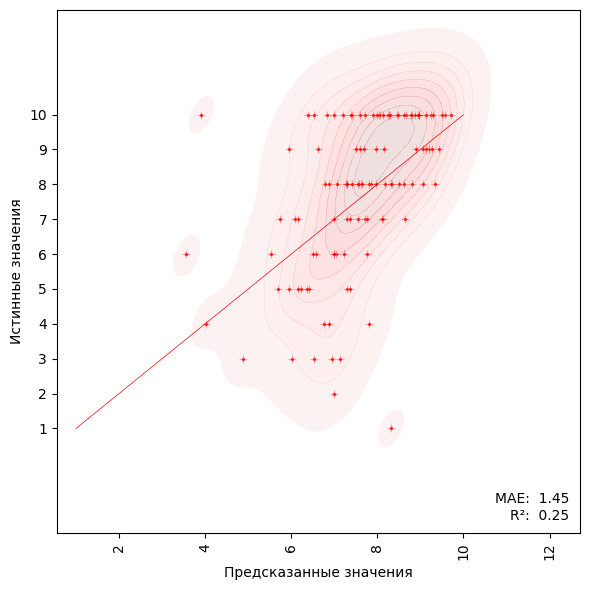

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.lineplot(x=[1, 10],
             y=[1, 10], ls='-', lw=0.5, c='#fa0000')

sns.kdeplot(y=y_test,
              x=preds, fill=True, color='#fa0000', alpha=.15)

sns.scatterplot(y=y_test,
              x=preds,
              s=30, color='#fa0000', marker=".", alpha=.8)

sns.scatterplot(y=y_test,
              x=preds,
              s=30, color='#fa0000', marker="+", alpha=.5)


plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.xticks(rotation=90)

plt.xlim([preds.min() - 3, preds.max() + 3])
plt.ylim([y_test.min() - 3, y_test.max() + 3])



local_mae = mean_absolute_error(y_test, preds)
mae_text = f'MAE:  {local_mae:.2f}'


local_r2 = r2_score(y_test, preds)
r2_text = f'R²:  {local_r2:.2f}'    


plt.yticks([i for i in range(1, 11)], [j for j in range(1, 11)])    
plt.text(x=0.98, y=0.02, ha='right', va='bottom', backgroundcolor='white',
         s= mae_text + '\n' + r2_text,
         transform=ax.transAxes)

plt.tight_layout()
plt.show()
plt.close()

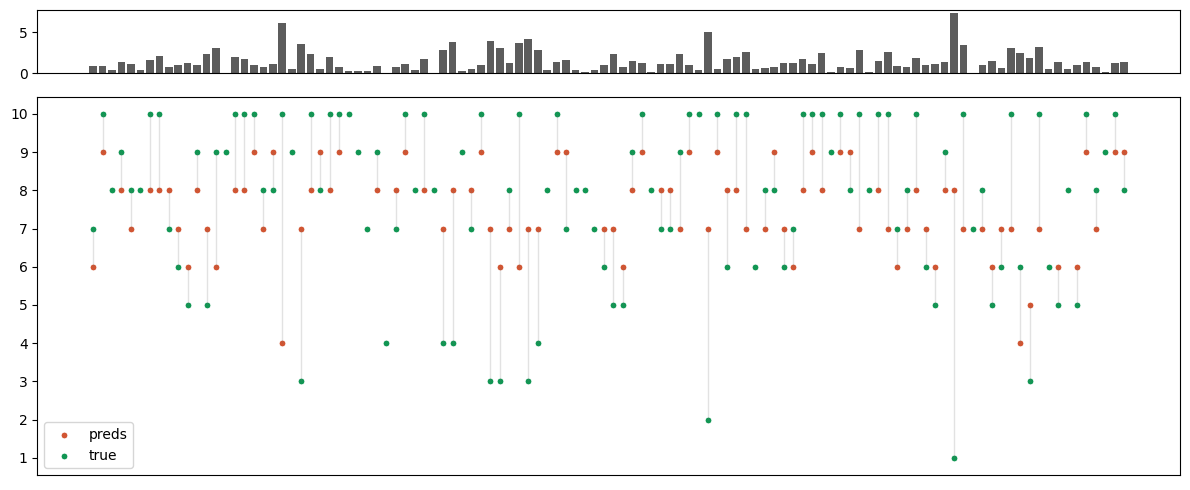

,true,preds,preds_raw,error
464,7,6,6.148981,0.851019
257,10,9,9.134361,0.865639
250,8,8,7.630618,0.369382
457,9,8,7.606047,1.393953
238,8,7,6.885538,1.114462
236,8,8,8.347819,0.347819
132,10,8,8.461871,1.538129
85,10,8,7.888340,2.11166
56,7,8,7.708043,0.708043
387,6,7,7.041634,1.041634


In [67]:
df_preds = pd.DataFrame({'true': y_test, 'preds_raw': preds})
df_preds['preds'] = df_preds.apply(lambda x: int(round(x['preds_raw'], 0)), axis=1)
df_preds['error'] = abs(df_preds['true'] - df_preds['preds_raw'])

fig, ax = plt.subplots(2, 1, figsize=(12, 5), height_ratios=[1, 6], sharex=True)

len_df_preds = [i for i in range(len(df_preds))]

sns.scatterplot(x=len_df_preds, y=df_preds['preds'], s=100, color='#d15532', marker=".", ax=ax[1], label='preds')
sns.scatterplot(x=len_df_preds, y=df_preds['true'], s=100, color='#119653', marker=".", ax=ax[1], label='true')
sns.barplot(x=len_df_preds, y=df_preds['error'], color='#5c5c5c', ax=ax[0])

for true, pred, xx in zip(df_preds['true'], df_preds['preds'], len_df_preds):
    sns.lineplot(x=[xx, xx],
                     y=[true, pred], ls='-', lw=0.5, c='#707070')


plt.xticks([])
plt.yticks([i for i in range(1, 11)])
plt.ylabel('')
plt.sca(ax[0])
plt.ylabel('')

plt.tight_layout()
plt.show()
plt.close()

display(df_preds[['true', 'preds', 'preds_raw', 'error']].head(10))

------